In [8]:
# %load user_clusters.py
import numpy as np
from kmodes import kprototypes
from sklearn.cluster import KMeans
import pickle
import pandas as pd
from datetime import date
from abc import abstractmethod
import os

def set_age(birthday):
    today = date.today()
    return today.year - birthday.year - ((today.month, today.day) < (birthday.month, birthday.day))


def set_sex(sex_str):
    if sex_str == 'female':
        return 0
    elif sex_str == 'male':
        return 1


def next_month(year, month):
    if month == 12:
        return year+1, 1
    else:
        return year, month+1


class UsersClusters:

    def __init__(self, num_clusters, data_dir='.'):
        with open(os.path.join(data_dir, 'bmi_steps_data.pickle'), 'rb') as f:
            self.bmi_steps = pd.DataFrame(pickle.load(f))
        with open(os.path.join(data_dir,'users_filter.pickle'), 'rb') as f:
            self.users = pd.DataFrame(pickle.load(f))

            self.users['age'] = self.users['birthday'].apply(lambda x: set_age(x))
            self.users['sex'] = self.users['sex'].apply(lambda x: set_sex(x))

            self.users_data = pd.merge(self.users, self.user_entries_per_month(), on='user_id')

            self.cluster_data = np.array(self.users_data[['sex', 'age', 'bmi']])

            self.clusters = self.find_clusters(num_clusters)

    @abstractmethod
    def find_clusters(self, num_clusters):
        return NotImplemented

    @abstractmethod
    def get_cluster(self, sex, age, bmi):
        return NotImplemented

    def user_entries_per_month(self):
        bmi_steps_month = self.bmi_steps.groupby(
            ['user_id', 'year', 'month'])['bmi', 'steps'].agg('mean')
        return bmi_steps_month.reset_index()

    def get_cluster_members(self, cluster_label):
        idx = [i for i, x in enumerate(self.clusters.labels_) if x == cluster_label]
        return self.users_data.iloc[idx]

    def recommender_user_sequence(self, sex, age, bmi, n_months):
        cluster_label = self.get_cluster(sex, age, bmi)
        cluster_members = self.get_cluster_members(cluster_label)
        return best_cluster_sequence(cluster_members, n_months)


class KMeansUsersClusters(UsersClusters):

    def find_clusters(self, num_clusters):
        clusters = KMeans(n_clusters=num_clusters)
        return clusters.fit(self.cluster_data)

    def get_cluster(self, sex, age, bmi):
        return self.clusters.predict(np.array([[sex, age, bmi]]))[0]


class KPrototypeUsersClusters(UsersClusters):

    def find_clusters(self, num_clusters):
        clusters = kprototypes.KPrototypes(n_clusters=num_clusters, init='Cao')
        return clusters.fit(self.cluster_data, categorical=[0])

    def get_cluster(self, sex, age, bmi):
        return self.clusters.predict(np.array([[sex, age, bmi]]), categorical=[0])[0]


def is_ordered_sequence(seq):
    for i in range(len(seq) - 1):
        if (seq[i + 1]['year'], seq[i + 1]['month']) != next_month(
                seq[i]['year'], seq[i]['month']):
            return False
    return True


def get_user_sequences(user_entries, n_months):
    user_entries.sort_values(['year', 'month'])
    user_sequences = []
    for i in range(len(user_entries)-n_months):
        seq = []
        for j in range(n_months):
            seq.append(user_entries.iloc[i+j])
        if is_ordered_sequence(seq):
            user_sequences.append(seq)
    return user_sequences


def best_user_sequence(user_entries, n_months):
    user_sequences = get_user_sequences(user_entries, n_months)
    first = True
    best_seq = None
    best_corr = None
    for seq in user_sequences:
        df = pd.DataFrame(seq)
        if df.bmi.std() < 0.01:
            continue
        cur_corr = df[['bmi','steps']].corr()['bmi']['steps']
        if first:
            first=False
            best_seq = seq
            best_corr = cur_corr
        elif cur_corr < best_corr:
            best_seq = seq
            best_corr = cur_corr
    return best_seq, best_corr


def best_cluster_sequence(cluster_members, n_months):
    best_cluster_seq = None
    best_cluster_corr = None
    first = True
    for user_id in set(cluster_members.user_id):
        user_entries = cluster_members[cluster_members.user_id == user_id]
        best_seq, best_corr = best_user_sequence(user_entries, n_months)
        if best_corr is None:
            continue
        if first:
            first = False
            best_cluster_seq = best_seq
            best_cluster_corr = best_corr
        elif best_corr < best_cluster_corr:
            best_cluster_seq = best_seq
            best_cluster_corr = best_corr
    return best_cluster_seq, best_cluster_corr


if __name__ == "__main__":
    user_id = '2a786a87-f00b-461a-90cd-c1a7a9a06f2e'
    year = 2016
    month = 2
    n_months = 6

    users_clusters = KMeansUsersClusters(18, data_dir='..')

    user_data = users_clusters.users_data[
        (users_clusters.users_data.user_id == user_id) &
        (users_clusters.users_data.year == year) &
        (users_clusters.users_data.month == month)]

    sex = user_data['sex'].values[0]
    age = user_data['age'].values[0]
    bmi = user_data['bmi'].values[0]
    print(sex,age,bmi)

    recommended_seq, corr = users_clusters.recommender_user_sequence(sex, age, bmi, n_months)
    print(recommended_seq[0]['sex'], recommended_seq[0]['age'], recommended_seq[0]['bmi'])
    #print(recommended_seq)





0 44 25.9424067359
0 44 27.209181221


In [25]:
user_id = '2a786a87-f00b-461a-90cd-c1a7a9a06f2e'
year = 2016
month = 2
n_months = 3

user_data = users_clusters.users_data[
    (users_clusters.users_data.user_id == user_id) &
    (users_clusters.users_data.year == year) &
    (users_clusters.users_data.month == month)]

sex = user_data['sex'].values[0]
age = user_data['age'].values[0]
bmi = user_data['bmi'].values[0]
print(sex,age,bmi)

recommended_seq, corr = users_clusters.recommender_user_sequence(sex, age, bmi, n_months)
print(recommended_seq[0]['sex'], recommended_seq[0]['age'], recommended_seq[0]['bmi'])
#print(recommended_seq)

0 44 25.9424067359
0 44 26.517008021


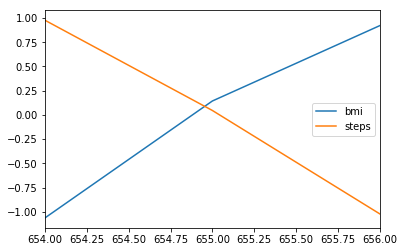

In [26]:
import matplotlib.pyplot as plt
df = pd.DataFrame(recommended_seq)[['bmi','steps']]
b_mi = df.bmi.mean()
b_std = df.bmi.std()
s_mi = df.steps.mean()
s_std = df.steps.std()
df['bmi'] = df['bmi'].apply(lambda x: (x - b_mi)/b_std)
df['steps'] = df['steps'].apply(lambda x: (x - s_mi)/s_std)
df[['bmi', 'steps']].plot()
plt.show()

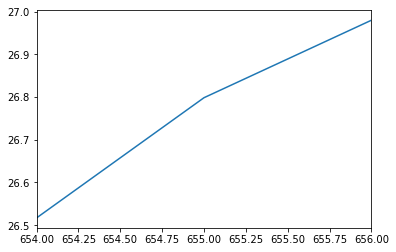

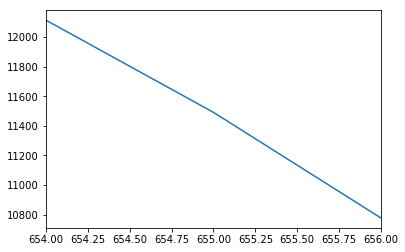

In [27]:
pd.DataFrame(recommended_seq)['bmi'].plot()
plt.show()
pd.DataFrame(recommended_seq)['steps'].plot()
plt.show()